https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [33]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [95]:
data_dir = 'data/'
batch_size = 4
learning_rate = 0.001
num_epochs = 25

In [36]:
data_transforms= { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x : datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) 
                  for x in ['train','val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = batch_size, shuffle= True) 
               for x in ['train','val'] }

dataset_sizes = {x : len(image_datasets[x]) 
                 for x in ['train','val']}
class_names = image_datasets['train'].classes

# print(class_names)


In [37]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    inp = std * inp + mean # to denormalize..
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

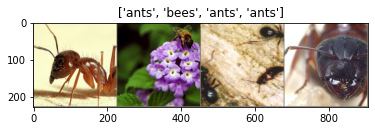

In [38]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [82]:
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs = 20):
    since= time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        
        print('epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 20)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            elif phase == 'val':
                model.eval()
                
            running_loss= 0.0
            running_corrects = 0
                
            for inputs,labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                    
#                     print('labels')
#                     print(labels)
                    
                optimizer.zero_grad()
                    
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) #1 is for the dimension row. Max returns the tuple (values,indices) of each row

                    loss = criterion(outputs, labels)
                        
                    if phase=='train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                 
                
            if phase=='train':
                lr_scheduler.step()
                    
                
            epoch_loss = running_loss/dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
                
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                
            if phase == 'val' and epoch_acc > best_acc :
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                    
                    
    time_elapsed =  time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [90]:
#time for fine-tuning (ft)

model_ft = models.resnet18(pretrained= True)
print(model_ft.training)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion= nn.CrossEntropyLoss()

optimizer_ft= optim.SGD(model_ft.parameters(), lr= learning_rate, momentum=0.0)

exp_lr_scheduler= lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

True


In [96]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=num_epochs)

epoch 0/24
--------------------
train Loss: 0.3619 Acc: 0.8361
val Loss: 0.2160 Acc: 0.9346
epoch 1/24
--------------------
train Loss: 0.4673 Acc: 0.7828
val Loss: 0.2105 Acc: 0.9412
epoch 2/24
--------------------
train Loss: 0.3618 Acc: 0.8484
val Loss: 0.2085 Acc: 0.9085
epoch 3/24
--------------------
train Loss: 0.4303 Acc: 0.7992
val Loss: 0.2870 Acc: 0.8889
epoch 4/24
--------------------
train Loss: 0.3498 Acc: 0.8402
val Loss: 0.2025 Acc: 0.9346
epoch 5/24
--------------------
train Loss: 0.3265 Acc: 0.8607
val Loss: 0.2068 Acc: 0.9281
epoch 6/24
--------------------
train Loss: 0.3809 Acc: 0.8156
val Loss: 0.2158 Acc: 0.9216
epoch 7/24
--------------------
train Loss: 0.3531 Acc: 0.8402
val Loss: 0.2027 Acc: 0.9281
epoch 8/24
--------------------
train Loss: 0.2890 Acc: 0.8770
val Loss: 0.2048 Acc: 0.9216
epoch 9/24
--------------------
train Loss: 0.3986 Acc: 0.7992
val Loss: 0.2329 Acc: 0.9085
epoch 10/24
--------------------
train Loss: 0.3329 Acc: 0.8811
val Loss: 0.2019

In [88]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return model.train(mode=was_training)
    

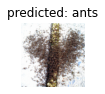

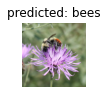

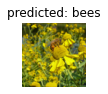

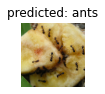

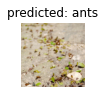

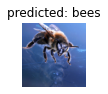

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [89]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().


In [99]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [100]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=num_epochs)

epoch 0/24
--------------------
train Loss: 0.6398 Acc: 0.6475
val Loss: 0.2598 Acc: 0.9281
epoch 1/24
--------------------
train Loss: 0.5236 Acc: 0.7336
val Loss: 0.2420 Acc: 0.9150
epoch 2/24
--------------------
train Loss: 0.4847 Acc: 0.7746
val Loss: 0.2766 Acc: 0.9085
epoch 3/24
--------------------
train Loss: 0.4409 Acc: 0.8115
val Loss: 0.2015 Acc: 0.9412
epoch 4/24
--------------------
train Loss: 0.4028 Acc: 0.8279
val Loss: 0.2991 Acc: 0.8889
epoch 5/24
--------------------
train Loss: 0.5746 Acc: 0.7951
val Loss: 0.4937 Acc: 0.8170
epoch 6/24
--------------------
train Loss: 0.4314 Acc: 0.8156
val Loss: 0.2671 Acc: 0.9281
epoch 7/24
--------------------
train Loss: 0.4964 Acc: 0.7992
val Loss: 0.1919 Acc: 0.9477
epoch 8/24
--------------------
train Loss: 0.3549 Acc: 0.8238
val Loss: 0.1756 Acc: 0.9477
epoch 9/24
--------------------
train Loss: 0.3545 Acc: 0.8443
val Loss: 0.1900 Acc: 0.9412
epoch 10/24
--------------------
train Loss: 0.2768 Acc: 0.8852
val Loss: 0.2220

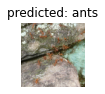

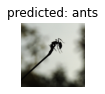

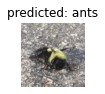

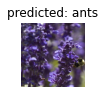

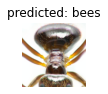

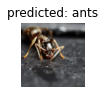

In [98]:
visualize_model(model_conv)

plt.ioff()
plt.show()